In [1]:
import numpy as np
import matplotlib.pyplot as plt
from apsuite.emittance_exchange.bo_tune_measure import tune_measure as tm
import pymodels as pm
import pyaccel as pa
#%config Completer.use_jedi = False
import pandas as pd
import seaborn as sns

# First step: estimates the necessary quadrupole variation to perform emittance crossing

Our objective is find the quadrupoles strength that makes $\Delta = \hat{Q}_x - \hat{Q}_y = 0$, in the machine without coupling. When we set some coupling, this configuration leads to emmitance crossing. 

The relation between the a variation in quadrupoles and a variation in tunes are:

\begin{equation}
d K = \pm \frac{4 \pi d Q}{\sum \beta_i l_i}
\end{equation}

where $\beta_i$ and $l_i$ refers to the average $\beta$-function over and
the length of quadrupole i, respectively. The sign depends
on the plane (positive for the horizontal plane and negative
for the vertical plane), and, similarly, the $\beta$ i is either the
horizontal or vertical $\beta$-function.

* Creating the machine

In [2]:
obj = tm.BPMeasure()
obj.create_booster(rad=False, QF_KL=None, KsL=None)
tune1, tune2 = obj._eqparams.tune1, obj._eqparams.tune2
delta = tune1%1 - tune2%1

print("Q_x = {:.2f}, Q_y = {:.2f}, Delta = {:.2f}".format(tune1, tune2, delta))

Q_x = 0.20, Q_y = 0.31, Delta = -0.11


We get that $\Delta < 0$, so we need to make a $\Delta Q>0$, that is, increase the QF forces. Lets find how much.

We want that $\Delta_0 + d\Delta =0$, so:

\begin{equation}
\hat{Q_1} + d \hat{Q_1} - \hat{Q}_2 - d\hat{Q}_2 = 0
\end{equation}

Assuming that, given a small variation in $dK$, the variation in tunes are equal and with opposite signs  $d\hat{Q}_1 = - d \hat{Q}_2$, we have:

\begin{equation}
 d\hat{Q}_1 = - \frac{\Delta_0}{2}
\end{equation}

Therefore, the needed variation in quadrupoles is
\begin{equation}
d K = + \frac{2 \pi \Delta_0}{\sum \beta_i l_i}
\end{equation}

In [3]:
qf_idx = obj._famdata['QF']['index']
spos = obj._et.spos
betax = obj._et.beta1

In [4]:
# Assuming that the QF quadrupoles have equally lengths:
l = obj._bo[qf_idx[0]].length
betas = np.zeros(len(qf_idx))

for i,idx in enumerate(qf_idx):
    idx1, idx2 = idx
    beta_values = betax[[idx1, idx2, idx2+1]]
    betas[i] = np.mean(beta_values)
sum_beta_l = np.sum(betas*l)

In [5]:
deltaK = 2*np.pi*np.abs(delta)/(sum_beta_l)
deltaKL = deltaK * l
print(" d K =", deltaK, "\n d KL =", deltaKL)

 d K = 0.0025996062269295016 
 d KL = 0.0005927102197399264


* Lets test this value with a new machine and check the tune values.

In [6]:
obj2 = tm.BPMeasure()
KL_default = obj2._QF_KL_default

KL_crossing = KL_default + deltaKL - 0.00011 # The last term is an euristic correction

obj2.create_booster(rad=False, QF_KL=KL_crossing)
tune1, tune2 = obj2._eqparams.tune1, obj2._eqparams.tune2

print(" QF KL force = {:.3f} \n Tune 1 = {:.3f} \n Tune 2 = {:.3f}".format(KL_crossing, tune1%1 , tune2%1))

 QF KL force = 0.189 
 Tune 1 = 0.294 
 Tune 2 = 0.294


# Checking the best point for extraction


Defining the function witch computes emittance exchange quality 

In [7]:
def calc_R(emit1_0, emit2_0,emit1):
    R = 1 - (emit1 - emit2_0)/(emit1_0 - emit2_0)
    return R

In [8]:
# Seting parameters
KsL = -0.02
N = 1000
offset = np.array(
    [[0.5e-3],
    [0],
    [0.1e-3],
    [0],
    [0],
    [0]]
    )

obj = tm.BPMeasure()
obj.create_booster(rad=True, KsL=KsL)
C = obj._coupling_coef
obj.create_initial_bunch(n_part=1000, offset=offset)
emit1_list, emit2_list, tune1_list, tune2_list = obj.emit_exchange_simulation(N, KL_crossing)

In [ ]:
R = calc_R(emit1_list[0], emit2_list[0], emit1_list)
N_s = np.arange(N)
#The below line is wrong, this delta is just a aproximmation
delta = (tune1_list - tune2_list)/C # Delta in units of C

Text(0.5, 0, '$\\Delta [C]$')

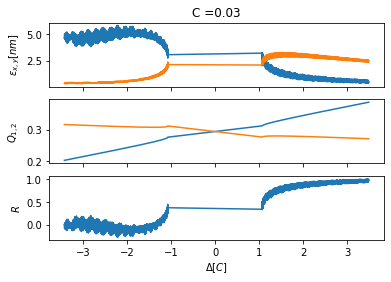

In [ ]:
fig, ax = plt.subplots(3,1,sharex = True)
ax[0].plot(N_s, emit1_list*1e9)
ax[0].plot(N_s, emit2_list*1e9)
ax[1].plot(N_s, tune1_list)
ax[1].plot(N_s, tune2_list)
ax[2].plot(N_s, R)
ax[0].set_title("C ={:.2f}".format(C))
ax[0].set_ylabel("$\epsilon_{x,y} [nm]$")
ax[1].set_ylabel("$Q_{1,2}$")
ax[2].set_ylabel("$R$")
ax[2].set_xlabel("$\Delta [C]$")

# Second step: Making the heat map of emittance exchange quality 

The rate of change of $\Delta$ can be defined in following way:

$\dot{\Delta} = d\Delta/N$

where $N$ is the number of revolutions that it takes to perform the **emittance crossing**.

Let's investigate the quality of emittance exchange in relation to this N number of revolutions

In [65]:
KsL_list = np.linspace(0, -0.02, num=10)
N_list = np.logspace(1, 3.5, num=10)
coupling_list = KsL_list.copy()
R_matrix = np.zeros([N_list.size, coupling_list.size])

In [66]:
for N_idx, N in enumerate(N_list):
    N = int(N)
    for C_idx, KsL in enumerate(KsL_list): 
        obj = tm.BPMeasure()
        obj.create_booster(rad=True, KsL=KsL)
        C = obj._coupling_coef
        coupling_list[C_idx] = C
        
        obj.create_initial_bunch(n_part=1000)
        
        step = (KL_crossing - KL_default)/N
        
        KL_list = np.arange(KL_default, 2*KL_crossing, step)
        
        emit1_list = np.zeros(2*N)
        emit2_list = emit1_list.copy()
        tune1_list, tune2_list = emit1_list.copy(), emit1_list.copy()
        bunch0 = obj._bunch
        
        #  Tracking with ring pass for 2N steps after teorical crossing.
        # The first N steps are to perfom emittance crossing and the last 
        # N are to complete the exchange.
        for i in range(2*N):
            obj.change_QF(KL=KL_list[i])
            bunch0, *_ = pa.tracking.ring_pass(accelerator=obj._bo, particles=bunch0, nr_turns=1, parallel=True)
            
            # Computing the RMS emittance
            emit1_list[i] = np.sqrt(np.linalg.det(np.cov(bunch0[:2,:])))
            emit2_list[i] = np.sqrt(np.linalg.det(np.cov(bunch0[2:4,:])))
            
            # Computing Tunes
            eqparams = pa.optics.EqParamsFromBeamEnvelope(obj._bo)
            tune1_list[i], tune2_list[i] = eqparams.tune1, eqparams.tune2
            
        R = calc_R(emit1=emit1_list[-1], emit1_0=emit1_list[0],
                  emit2_0=emit2_list[0])
        R_matrix[C_idx, N_idx] = R

In [69]:
np.save("R_matrix", R_matrix)

Text(33.0, 0.5, 'Coupling')

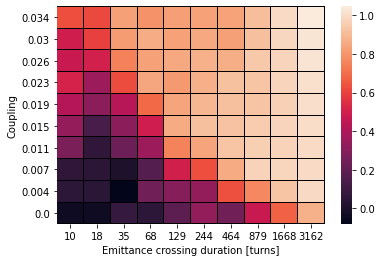

In [79]:
R_df = pd.DataFrame(R_matrix, index = np.round(coupling_list,3), columns=N_list.astype('int'))
R_df = R_df.reindex(index=R_df.index[::-1])
sns.heatmap(R_df, linewidths=.05, linecolor='k')
plt.xlabel("Emittance crossing duration [turns]")
plt.ylabel("Coupling")